# MADE

To model the conditionals $p(x_i \mid \mathbf{x}_{<i})$, we can also use models that handle a fixed number of input. An alternative approach is to mask future tokens before passing them into the network. An early attempt at this approach was made by Uria et al. with their Neural Autoregressive Distribution Estimation (NADE) model. They model the conditional distribution using a shared feedforward network, defined as

$$
\begin{align*}
    p(x_{d}=1|\mathbf{x}_{<d}) &= \text{sigmoid}(\mathbf{V}_{d, \cdot}\;\mathbf{h}_d+b_{d})\\
    \mathbf{h}_d &= \text{sigmoid}(\mathbf{W}_{.,<d}\;\mathbf{x}_{<d}+\mathbf{c})\\
\end{align*}
$$

One issue with NADE is that computing the conditional probability for all $D$ variables requires $D$ feedforward passes, making training costly. An improvement over NADE is proposed by Germain et al. in the Masked Autoencoder for Distribution Estimation (MADE). The authors extended the idea of modeling conditionals with a feedforward network and introduced a clever scheme that allows evaluating the probability $p(\mathbf{x})$ with a single pass.

## MADE architecture

MADE is an autoencoder feedforward network with a special masking scheme. In each hidden layer, neuron $k$ is randomly assign a number $m(k)$ uniformly chosen from $1$ to $D-1$. The mask matrix $\mathbf{M}$ is then defined as 

$$
\begin{equation*}
\mathbf{M}_{k, d}^H = 
\begin{cases}
1\hspace{5mm}\text{if}\;d \leq m(k)\\
0\hspace{5mm}\text{otherwise}
\end{cases}
\end{equation*}
$$

In other words, neurons from the previous layer can only connect to neurons in the next layer with equal or greater index values. For example, a node with value $2$ can only connect to nodes with value $1$ or $2$ in the previous layer. However, if the same masking scheme is applied to the last layer, a node could end up depending on itself. To address this, the authors modified the masking matrix of the output layer by changing the "less than or equal to" condition to "strictly less than."

$$
\begin{equation*}
\mathbf{M}_{k, d}^O = 
\begin{cases}
1\hspace{5mm}\text{if}\;m(d)<k\\
0\hspace{5mm}\text{otherwise}
\end{cases}
\end{equation*}
$$

Now, a neuron with value $2$ can only depend on neurons with values less than $2$ in the previous layer. This ensures that the autoregressive property is hold. An illustration of the masking scheme is provided in Figure 1.


<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/MADE.gif" style="max-width: 45%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: MADE masking scheme
</p>

In the original paper, the authors proved that the autoregressive property is preserved with this masking scheme. In particular, note that the matrix product $\mathbf{M}^O \mathbf{M}^H$ represents the connectivity from the input layer to the output layer. To demonstrate that the autoregressive property is preserved, it is sufficient to show that $\mathbf{M}^O \mathbf{M}^H$ is lower triangular. This can be checked directly

$$
\begin{align*}
(\mathbf{M}^O \mathbf{M}^H)_{a, b} &= \sum_{k} \mathbf{M}^O_{a, k}\mathbf{M}^H_{k, b}\\
&= \sum_k \mathbb{1}_{m(k)\leq a}\mathbb{1}_{b\leq m(k)}\\
&= \sum_k \mathbb{1}_{b \leq m(k)\leq a}
\end{align*}
$$

If $a< b$, then there are no $m(k)$ that makes $b \leq m(k)\leq a$. Therefore, $(\mathbf{M}^O \mathbf{M}^H)_{a, b}=0$ for all $a<b$. This proves that the connectivity matrix is indeed lower diagonal and thus autoregressive property holds. In the following section, we implement MADE from scratch and test it on the binarized MNIST data.

## MADE Implementation

For the implementation of MADE, we allow arbitrary permutation of the input and output sequence, as long as they are the same. Formally, let $\sigma$ be any permutation function, MADE allows modeling

$$p(\mathbf{x}) = \prod_{i=1}^D p(x_{\sigma(i)}|\mathbf{x}_{\sigma(<i)})$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from MADE import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

batch_size = 64
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class MaskedLinear(nn.Linear):
    """
    Implementation of masked linear layer, a linear layer with nonlearnable mask
    """
    def __init__(self, in_dim, out_dim, bias=True, device="cpu"):
        super(MaskedLinear, self).__init__(in_dim, out_dim, bias)
        self.mask = torch.ones(out_dim, in_dim).to(device)
        self.mask.requires_grad = False

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    """
    Implementation of MADE
    Assume that input dimension = output dimension
    """
    def __init__(self, max_len, hidden_dims, n_masks=1, order=None, device="cpu"):
        """
        @param max_len: int
        @param hidden_dims: int
        @param n_masks: int
            Number of masks used in MADE
        @param order: list
            The ordering of input/output nodes (default raster order)
        @param: device: string
        """
        super(MADE, self).__init__()
        self.max_len = max_len
        self.device = device
        self.hidden_dims = [max_len] + hidden_dims + [max_len]
        self.init_order = np.arange(max_len) if order is None else order
        self.sample_masks(n_masks)
        self.net = [MaskedLinear(max_len, hidden_dims[0]), nn.ReLU()]
        for i in range(1, len(hidden_dims)):
            self.net.extend([MaskedLinear(hidden_dims[i-1], hidden_dims[i]),
                             nn.ReLU()])
        self.net.append(MaskedLinear(hidden_dims[-1], max_len))
        self.net = nn.Sequential(*self.net)
        self.n_masks = n_masks
        self.mask_idx = 0
        self.update_masks()

    def sample_masks(self, n_masks=1):
        """
        Predefine a list of masks that will be sampled during training
        """
        self.masks = []
        for k in range(n_masks):
            masks = []
            prev_order = self.init_order
            for i in range(1, len(self.hidden_dims)):
                last_layer = i == len(self.hidden_dims) - 1
                if last_layer:
                    curr_order = self.init_order
                else:
                    curr_order = np.random.randint(prev_order.min(), self.max_len-1, size=self.hidden_dims[i])
                mask = self.create_mask(prev_order, curr_order, last_layer)
                masks.append(mask)
                prev_order = curr_order
            self.masks.append(masks)

    def create_mask(self, prev_order, curr_order, last_layer):
        """
        Helper function for sample_masks, given the ordering of previous layer and current layer,
        generates the mask according to (8), (9) in the MADE paper
        @param prev_order: list
        @param curr_order: list
        @param last_layer: boolean
            True if current layer is the last layer
        """
        if not last_layer:
            mask = torch.from_numpy((prev_order[:, None] <= curr_order[None, :])).float().T
        else:
            mask = torch.from_numpy((prev_order[:, None] < curr_order[None, :])).float().T
        return mask.to(self.device)

    def update_masks(self):
        """
        Update each layers' mask from the predefined set of masks
        """
        masks = self.masks[self.mask_idx]
        self.mask_idx = (self.mask_idx + 1) % len(self.masks)
        layers = [l for l in self.net if isinstance(l, MaskedLinear)]
        for i, layer in enumerate(layers):
            layer.mask = masks[i]

    def forward(self, x):
        """ 
        @param: torch.tensor of shape [B, L]
        """
        return self.net(x)

    def sample(self, n_samples, device="cpu"):
        """ 
        @param n_samples: int
        """
        self.eval()
        samples = torch.zeros(n_samples, self.max_len).to(DEVICE)
        for i in range(self.max_len):
            self.mask_idx = 0
            logits = torch.zeros(n_samples, device=DEVICE)
            for j in range(self.n_masks):
                self.update_masks()
                logits += self.forward(samples)[:, self.init_order[i]].to(DEVICE)
            logits /= self.n_masks
            prob = F.sigmoid(logits)
            samples[:, self.init_order[i]] = torch.bernoulli(prob)
        samples = samples.reshape(n_samples, 1, 28, 28).detach().cpu().numpy()
        return samples

We construct a MADE with 1 hidden layer with $500$ units. The model is trained for $20$ epochs using Adam optimizer with learning rate of $10^{-3}$. The generated image indeed resembles true handwritten digits, but it seems to be a bit noisy. 

In [ ]:
made = MADE(max_len=28*28, hidden_dims=[500], n_masks=1, device=DEVICE)
optimizer = optim.Adam(made.parameters(), lr=1e-3)
train(made, train_loader, optimizer, n_epochs=20, batch_size=batch_size, device=DEVICE)

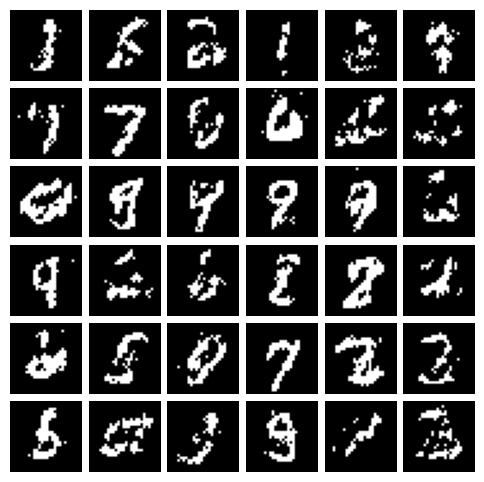

In [ ]:
plot_samples(made, n_samples=36, device=DEVICE)

## Connectivity-agnostic training

In the paper, the authors also experimented with connectivity-agnostic training. In other words, during training, the model resamples the mask used by the hidden layers for each minibatch. However, sampling from an infinite set of masks could over-regularize the model. To mitigate this, the authors instead sample from a finite list of masks. During testing, the probabilities for each mask are averaged to produce a final result.


We also tested this approach by training 7 models with different numbers of masks ($1$, $2$, $4$, $8$, $16$, $32$, and $64$). This was achieved by adjusting the `n_masks` parameter in the `sample_masks` method, which, during the initialization of a MADE model instance, samples a list of masks to be used during training. Each model used a single-layer network with 500 hidden units and was trained until its training loss converged. The mask was resampled every 5 steps. The testing losses for these models are shown below.

We see that using approximately 4 masks yields the lowest test error. The shape of the test loss curve is consistent with the results reported in the paper.

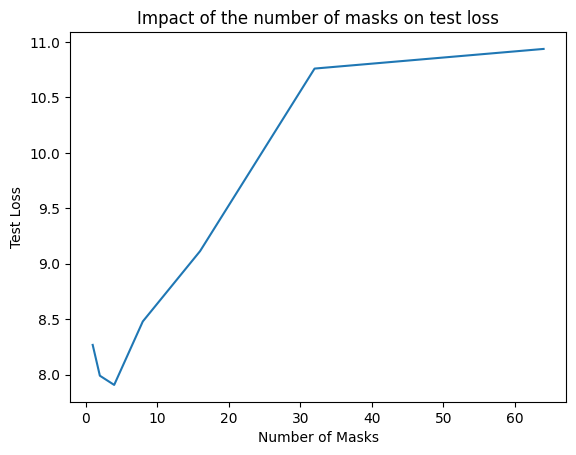

In [ ]:
plt.plot(n_masks, test_loss)
plt.xlabel("Number of Masks")
plt.ylabel("Test Loss")
plt.title("Impact of the number of masks on test loss")
plt.show()

## Ordering of input

We also tested different orderings of the inputs and outputs. We found that orderings A, B, and D (raster order, transposed raster order, and scan order) perform well. Among these, the transposed raster order produces less noisy images compared to the others. In contrast, a random ordering fails to generate realistic images. This suggests that the design of the input ordering is also important in MADE.

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/MADE_order.png" style="max-width: 80%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 2 </strong>: Different ordering of inputs
</p>

<p style="font-size: 24px; font-weight: bold;">
    Order A (Raster order)
</p>

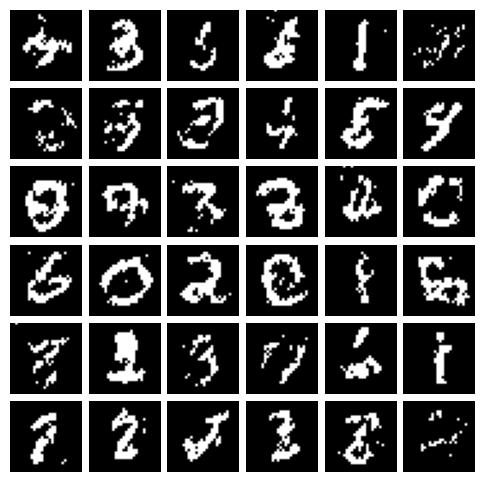

In [ ]:
order = np.arange(784)
made = MADE(max_len=28*28, hidden_dims=[500], n_masks=1, order=order, device=DEVICE)
optimizer = optim.Adam(made.parameters(), lr=1e-3)
train(made, train_loader, optimizer, n_epochs=10, batch_size=batch_size, device=DEVICE)
plot_samples(made, n_samples=36, device=DEVICE)

<p style="font-size: 24px; font-weight: bold;">
    Order B (Transposed raster order)
</p>

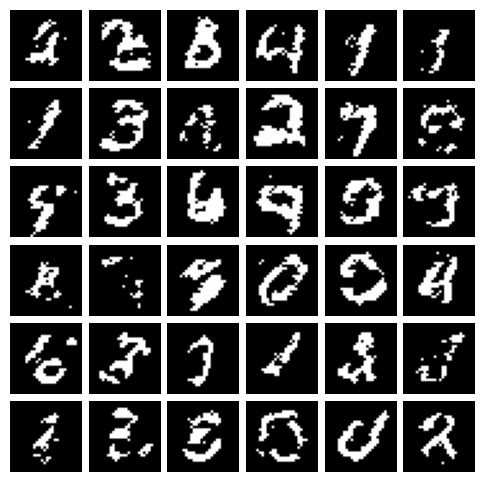

In [ ]:
order = np.arange(784).reshape(28, 28).T.reshape(-1)
made = MADE(max_len=28*28, hidden_dims=[500], n_masks=1, order=order, device=DEVICE)
optimizer = optim.Adam(made.parameters(), lr=1e-4)
train(made, train_loader, optimizer, n_epochs=20, batch_size=batch_size, device=DEVICE)
plot_samples(made, n_samples=36, device=DEVICE)

<p style="font-size: 24px; font-weight: bold;">
    Order C (Random order)
</p>

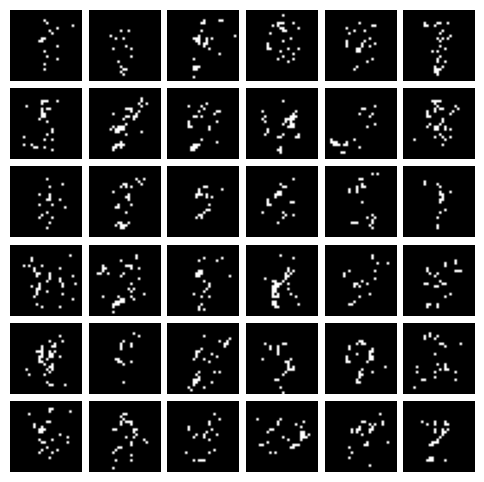

In [ ]:
order = np.random.permutation(784)
made = MADE(max_len=28*28, hidden_dims=[500], n_masks=1, order=order, device=DEVICE)
optimizer = optim.Adam(made.parameters(), lr=1e-3)
train(made, train_loader, optimizer, n_epochs=20, batch_size=batch_size, device=DEVICE)
plot_samples(made, n_samples=36, device=DEVICE)

<p style="font-size: 24px; font-weight: bold;">
    Order D (Scan order)
</p>

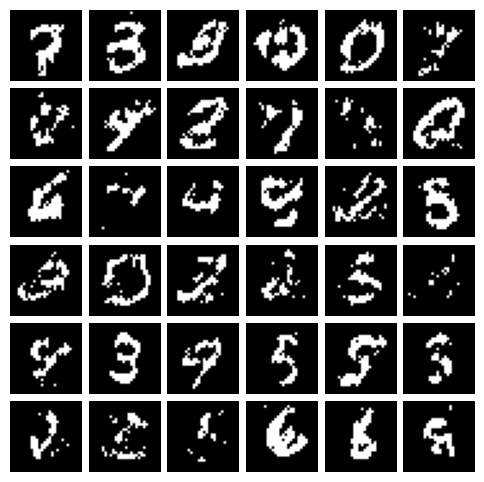

In [ ]:
order = np.array([row if i % 2 == 0 else row[::-1] for i, row in enumerate(np.arange(28**2).reshape(28, 28))]).flatten()
made = MADE(max_len=28*28, hidden_dims=[500], n_masks=1, order=order, device=DEVICE)
optimizer = optim.Adam(made.parameters(), lr=1e-3)
train(made, train_loader, optimizer, n_epochs=10, batch_size=batch_size, device=DEVICE)
plot_samples(made, n_samples=36, device=DEVICE)

## Citation

[1] https://arxiv.org/pdf/1502.03509 <br>
[2] https://arxiv.org/pdf/1605.02226 <br>
[3] https://courses.cs.washington.edu/courses/cse599i/20au/resources/L04_nade.pdf